In [7]:
import numpy as np
import plotly.graph_objects as go
from IPython.display import Markdown, display
from plotly.offline import init_notebook_mode
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

# These were calculated from data
PARAMS = (4.816931830999022, 0.23815199140828144, 0.7144975482181155)


# Define the bi-exponential model
def bi_exponential(t, Cmax, Ka, Ke):
    return (Cmax * Ka / (Ka - Ke)) * (np.exp(-Ke * t) - np.exp(-Ka * t))


# Function to calculate model predictions using the fitted parameters
def predict_concentration(t, Cmax, Ka, Ke, dose):
    return bi_exponential(t, Cmax, Ka, Ke) * dose


# Function to calculate total and individual concentrations over time
def total_and_individual_concentration_over_time(dose_times, params):
    # Generate a time array for the day from 5 AM to midnight, assuming minute intervals
    time_array = np.linspace(5, 24, (24 - 5) * 60)  # Minute intervals
    total_concentration = np.zeros_like(time_array)
    individual_concentrations = []

    for dose_time, dose_amount in dose_times:
        # Calculate time passed since the dose was taken
        time_since_dose = time_array - dose_time
        # Calculate individual concentration
        individual_concentration = np.where(
            time_since_dose > 0,
            predict_concentration(time_since_dose, *params, dose_amount),
            0,
        )
        # Update total concentration
        total_concentration += individual_concentration
        individual_concentrations.append(individual_concentration)

    return time_array, total_concentration, individual_concentrations


# Function to calculate concentrations and plot with Plotly
def calculate_concentrations_and_plot_with_plotly(dose_time_options, threshold=30):
    fig = make_subplots(rows=1, cols=1)

    for i, dose_times in enumerate(dose_time_options, 1):
        time_array, total_concentration, individual_concentrations = (
            total_and_individual_concentration_over_time(dose_times, PARAMS)
        )

        # Adding individual concentration traces
        for j, concentration in enumerate(individual_concentrations, start=1):
            fig.add_trace(
                go.Scatter(
                    x=time_array,
                    y=concentration,
                    mode="lines",
                    name=f"{dose_times[j-1][1]}mg",
                    line=dict(dash="dot", color="darkgrey"),
                ),
                row=1,
                col=1,
            )

        # Adding total concentration trace
        fig.add_trace(
            go.Scatter(
                x=time_array,
                y=total_concentration,
                mode="lines",
                name=f"Total Concentration Option {i}",
                line=dict(width=2),
            ),
            row=1,
            col=1,
        )

    # Adding a horizontal line for the threshold concentration
    fig.add_hline(y=threshold, line_color="black", line_width=2, row=1, col=1)

    # Updating layout to make it look nice
    fig.update_layout(
        title="Total and Individual Medication Concentrations Over Time",
        xaxis_title="Hour of the Day",
        yaxis_title="Concentration (ng/mL)",
        legend_title="Concentration Type",
        xaxis=dict(range=[5, 24], dtick=1),  # Hourly ticks from 5 to 24
        template="plotly_white",
    )

    return fig

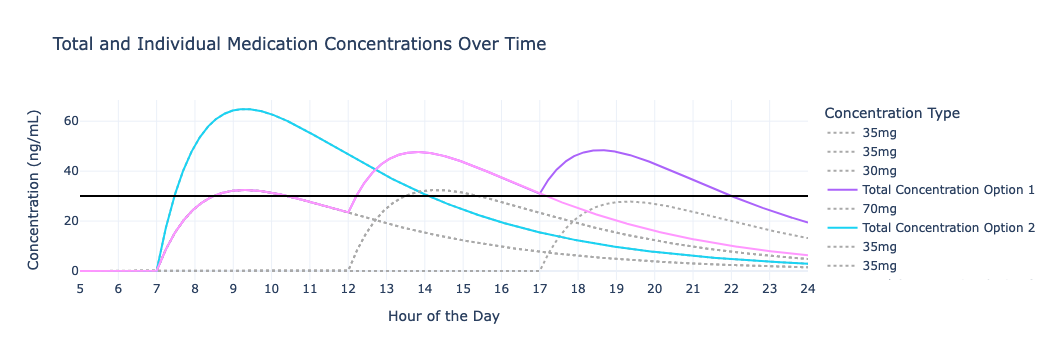

In [9]:
medication_options = [[[7, 35], [12, 35], [17, 30]], [[7, 70]], [[7, 35], [12, 35]]]
calculate_concentrations_and_plot_with_plotly(medication_options)